# Sampling from equally divided space

In [1]:
import sys

sys.path.append('..')

from relu_nets import ReLUNet  
from hyperbox import Hyperbox  
from lipMIP import LipMIP
from helper_functions_demo import *
from other_methods import StochasticApproximationEqDiv

In [2]:
def get_relative_error(true, approximated):
    return np.abs((true - approximated) / true) * 100

In [3]:
DIMENSION = 2
rad = 25.0
domain = Hyperbox.build_custom_hypercube(DIMENSION, center=0.0, radius=rad)
c_vector = torch.tensor([1.0])
test_network = ReLUNet([DIMENSION, 8, 8, 8, 1])

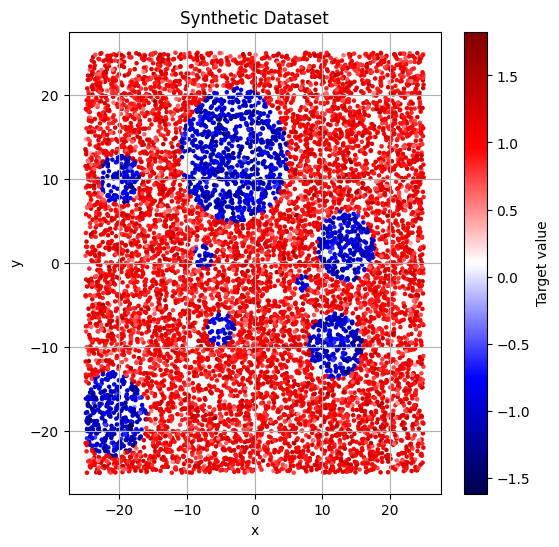

Epoch 0: Loss: 0.9056
Epoch 50: Loss: 0.7716
Epoch 100: Loss: 0.7087
Epoch 150: Loss: 0.6462
Epoch 200: Loss: 0.6141
Epoch 250: Loss: 0.5973
Epoch 300: Loss: 0.5841
Epoch 350: Loss: 0.5734
Epoch 400: Loss: 0.5636
Epoch 450: Loss: 0.5527


In [4]:
# Train NN
num_points = 10000
X = np.random.uniform(-rad, rad, size=(num_points, 2))
X = torch.Tensor(X)

lakes = [((-7.5, 0.9), 1.5), ((-20, 10), 3.0), ((-5, -8), 2), ((13.5, 2), 4.2), ((-3, 12.8), 8), ((7, -2.4), 1.0), ((12, -9.8), 4), ((-21, -18), 5.0)]

def is_in_region(point):
    return any(np.linalg.norm(point - np.array(center)) < radius for center, radius in lakes)

y = np.array([-1.0 if is_in_region(p) else 1.0 for p in X])
y += np.random.normal(scale=0.2, size=y.shape)
y = torch.Tensor(y)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='seismic', s=5)
plt.colorbar(label="Target value")
plt.title("Synthetic Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

train_X = X[:int(num_points * 0.8)]
train_y = y[:int(num_points * 0.8)].unsqueeze(1)
test_X = X[int(num_points * 0.8):]
test_y = y[int(num_points * 0.8):].unsqueeze(1)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(test_network.parameters(), lr=5e-4)

epochs = 500
for epoch in range(epochs):
    test_network.train()
    pred = test_network(train_X)
    loss = loss_fn(pred, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        test_network.eval()
        pred = test_network(test_X)
        loss = loss_fn(pred, test_y)
        print(f"Epoch {epoch}: Loss: {loss.item():.4f}")

maximum = 0.16057530045509338 on (0.0 2.625)


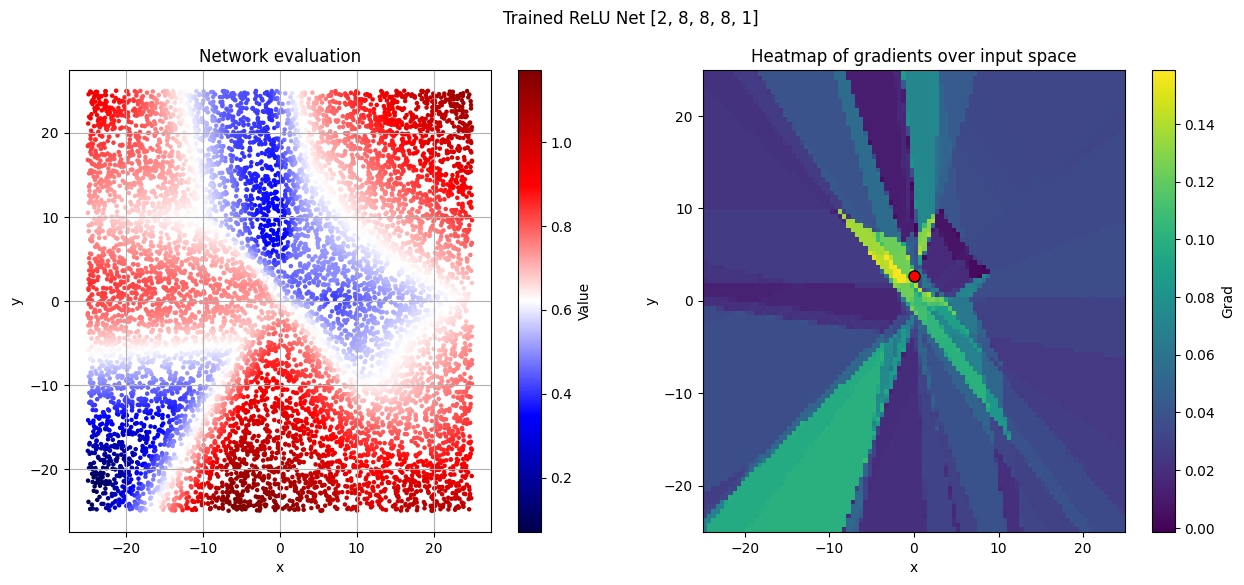

maximum = 0.16057530045509338 on (0.0 2.625)


In [5]:
PIXELS = 400
XS, GS, maximum, maximum_x, maximum_y = get_xs_gs_maximum(net=test_network, radius=rad, dimension=DIMENSION, px=PIXELS, v=False, c_vector=c_vector)
plot_value_and_grads(net=test_network, domain=domain, radius=rad, dimension=DIMENSION, is_trained=True, px=PIXELS)

In [6]:
simple_prob = LipMIP(network=test_network, domain=domain, c_vector=c_vector, verbose=False, num_threads=5)
simple_result = simple_prob.compute_max_lipschitz()
LipMIP_result = simple_result.as_dict()["value"]
LipMIP_result

0.16662022332450724

In [7]:
sample_budget = 2000
SA_eq_div = StochasticApproximationEqDiv(network=test_network, c_vector=c_vector, domain=domain, divisions_per_dimension=5, use_c_vector=True)
r_eq_div = SA_eq_div.compute(v=False, total_iterations=sample_budget, track_evaluations=True)
print(f"result={r_eq_div}, error={get_relative_error(LipMIP_result, r_eq_div):.5f}%")

result=0.15595421195030212, error=6.40139%


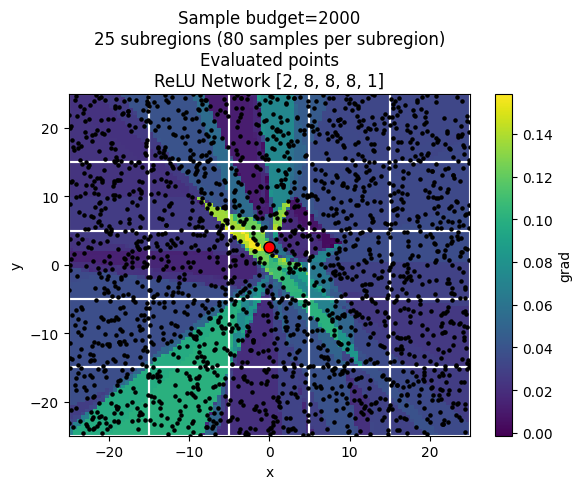

In [8]:
plot_evaluated_points(net=test_network, radius=rad, xs=XS, gs=GS, mxx=maximum_x, mxy=maximum_y, regs=SA_eq_div.regions, evaluated_points=np.array(SA_eq_div.eval_list), sample_budget=sample_budget)

In [9]:
max_div = 44
sample_budget = 2000
samples=100
errors = np.zeros((max_div, samples))
for i in range(max_div):
    for j in range(samples):
        SA_eq_div = StochasticApproximationEqDiv(network=test_network, c_vector=c_vector, domain=domain, divisions_per_dimension=(i + 1))
        r_eq_div = SA_eq_div.compute(v=False, total_iterations=sample_budget, exact=None)
        errors[i, j] = get_relative_error(LipMIP_result, r_eq_div)

Text(0, 0.5, 'Relative error (%)')

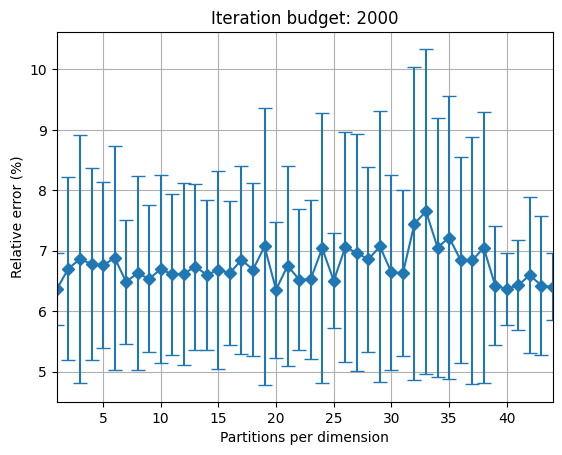

In [10]:
plt.errorbar(np.arange(1, len(errors.mean(axis=1))+1), errors.mean(axis=1), yerr=errors.std(axis=1), fmt='D-', capsize=5)
plt.title(f"Iteration budget: {sample_budget}")
plt.xlim(1, len(errors.mean(axis=1)))
plt.xlabel("Partitions per dimension")
plt.grid(True)
plt.ylabel("Relative error (%)")